# Mise en qualité des données

L'objectif de cette première partie est de mettre en évidence les **problèmes de qualité de données** (données incohérentes, données manquantes données dupliquées, etc.). Les données sont synthétiques et correspondent à la géographie de l'Australie.



**1 – Importation des modules**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.coherence import convert_to_date, calculate_age, correct_typo, postcode_coherence
from utils.coherence import find_best_similar, find_best_similar_levenstein, gestalt_pattern_matching
from utils.coherence import apply_coherence

from utils.data import get_postcode, get_states
from utils.deduplicate import Duplication, prepare_patient, prepare_pcr
from utils.getting_started import df_patient, df_pcr

from jellyfish import jaro_winkler_similarity

**2 – Spécification des paramètres**

In [2]:
color = (0.1,0.2,0.6)
plt.style.use('seaborn-whitegrid')

## Observation de la base de données

Une première étape consiste à afficher un extrait des données. On peut également observer les dimensions de chacune des tables.

In [3]:
df_patient.head()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None


In [4]:
df_pcr.head()

,patient_id,pcr
0,653091,N
1,347667,Negative
2,708481,Positive
3,148825,Negative
4,150081,Negative


In [5]:
print('Patient :', df_patient.shape)
print('pcr :', df_pcr.shape)

Patient : (20000, 12)
pcr : (8800, 2)


On commence par créer une copie du jeu de données.

In [6]:
df_patient_copy = df_patient.copy()

## Comptage des valeurs manquantes

Les données correspondent à des données (déclaratives ?) de personnes ayant effectuées un test pcr pour la Covid 19 en Australie. On remarque des variables telles que :
>- nom, prénom, 
>- age, date de naissance, 
>- numéro de rue, adresse, région et code postal, 
>- numéro de téléphone 
>- une seconde adresse.

Une première étape pour juger de la qualité des données est de voir la part de valeurs manquantes (en %) pour chacune des variables.

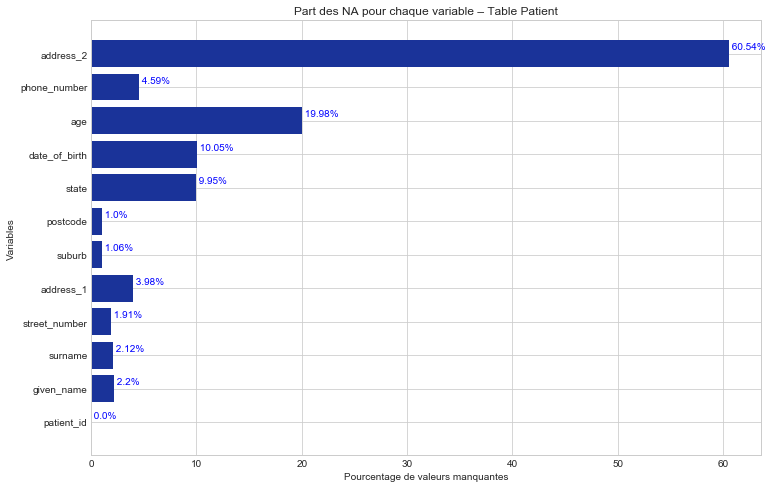

In [8]:
pourc_na = list(df_patient.isna().sum() / df_patient.shape[0] * 100)

plt.figure(figsize=(12, 8))
plt.title('Part des NA pour chaque variable – Table Patient')
plt.barh(df_patient.columns, pourc_na,
         color=color)
plt.xlabel('Pourcentage de valeurs manquantes')
plt.ylabel('Variables')

for i, v in enumerate(pourc_na):
    plt.text(v, i+0.2, " "+str(round(v, 2))+"%", color='blue', va='center')

Pour la table `pcr` :

In [9]:
df_pcr.isna().sum()

patient_id    0
pcr           0
dtype: int64

Certaines valeurs sont manquantes dans la table `patient`. Notamment, pour la variable `adresse_2` avec 12 100 valeurs manquantes (60%) et `age` avec environ 4 000 valeurs manquantes (20%). On ne comptabilise aucune valeur manquante pour la table `pcr`.

## Table PCR : Cohérence des variables

Pour la variable `pcr`, on remarque que les modalités sont différentes. On peut harmoniser les modalités en ne conservant qu'une seule nomenclature.

In [10]:
df_pcr.pcr.value_counts()

N           3482
Negative    3134
Positive    1283
P            901
Name: pcr, dtype: int64

In [11]:
df_pcr.pcr = df_pcr.pcr.replace({'Negative': 'N', 'Positive': 'P'})

In [12]:
df_pcr.pcr.value_counts()

N    6616
P    2184
Name: pcr, dtype: int64

Pour la variable `patient_id`, on remarque que 70 valeurs sont dupliquées

In [13]:
all_pcr_duplicated = df_pcr.patient_id[df_pcr.patient_id.duplicated(False)]
len(all_pcr_duplicated)

70

On va considérer comme valeur dupliquées lorsque **l'identifiant du patient et son test sont identiques**. On pourrait supposer qu'un individu se fasse tester deux fois, mais on ne possède pas d'indications pour différencier les deux tests (par exemple une date). Il s'agit donc ici de véritables données dupliquées qui peuvent être retirés.

In [14]:
dupli_pcr_test = df_pcr[df_pcr.duplicated(subset=["patient_id","pcr"], keep=False)]
len(dupli_pcr_test)

42

In [15]:
not_dupli_pcr = df_pcr[df_pcr.duplicated(subset=["patient_id","pcr"], keep='first')]

Les valeurs restantes sont celles qui ont un **identifiant identique**, mais un résultat **pcr différent**.

In [16]:
dupli_pcr_testdiff = df_pcr.iloc[np.setdiff1d(all_pcr_duplicated.index, dupli_pcr_test.index)]
len(dupli_pcr_testdiff)

28

L'objet de l'exercice étant l'analyse de la prévalence de la maladie dans la population, on peut considérer qu'un test positif est plus important qu'un test négatif, dans le cas d'un même patient.

In [17]:
positive_pi = dupli_pcr_testdiff[dupli_pcr_testdiff.pcr == 'P']

## Table Patient : Cohérence des variables

Focalisons nous sur les variables de la table patient :  
- `date_of_birth` et `age` : ces deux variables sont assez redondantes car fournissent la même information. Un premier moyen de juger de la cohérence de ce jeu de données et de vérifier si **l'age et la date de naissance corroborent**.


- `postcode` et `state` : on peut vérifier si les informations de localisation sont **cohérents entre eux** (le code postal appartient bien à l'état) et au **sein des modalités possibles** (les codes postaux sont bien des nombres, les états renseignés existent).


- `surburb` et `adresss` : on peut **corriger les petites erreurs typographiques** quand la valeur ressemblent beaucoup à une valeur déjà présente dans le jeu de données (avec une confiance très élevée pour éviter une mauvaise transformation).


- `id` : il s'agit d'un identifiant unique, on peut donc vérifier la présence de **doublons** si deux `id` sont identiques.

### La date de naissance et l'âge

La première étape consiste à convertir les `dates` dans un format lisible. 

In [18]:
col_date = df_patient.date_of_birth.apply(convert_to_date)

En vérifiant les dates qui n'ont pas pu être converties (en dehors des NA), on observe que certaines dates sont invraisemblables au niveau des mois (donc ne sont pas convertibles). Par exemple : $1903/05/39$, $1954/12/42$ ou $1999/03/53$. 

174 observatiosn sont dans ce cas. 

In [19]:
date_noconvert = col_date[[isinstance(value, str) for value in col_date]]

In [20]:
compare_date = pd.DataFrame([df_patient.age[date_noconvert.index],date_noconvert]).T
print(len(compare_date))
compare_date.head()

174


,age,date_of_birth
40,36,19030539
145,24,19179318
244,39,19541242
481,NaN,19990353
539,39,19328814


En pratique, le mois et le jour de naissance ne nous sont pas utiles. On peut donc seulement retenir l'année de naissance. 

Pour vérifier la cohérence entre l'age et la date de naissance, on peut observer si l'age correspond à la date de naissance du patient.

In [21]:
list_matching = []

for i in range(2019, 2022):
    df_patient["age_calculate"] = calculate_age(df_patient.date_of_birth, i)
    matching = df_patient[df_patient.age_calculate == df_patient.age].shape[0]
    print(f"{i} :", matching)
    list_matching.append(matching)
print(f"Total matching : {(sum(list_matching) / df_patient.shape[0]) * 100}%")

2019 : 121
2020 : 106
2021 : 119
Total matching : 1.73%


On remarque que pour la plupart des dates de naissance renseignés, l'année de naissance par rapport à 2020 ne correspond pas avec l'âge renseigné par le patient. Si nous considérons une marge d'erreur de +/- 1 an, les résultats ne correspondent pas également. On constate donc de nombreuses erreurs de cohérences avec seulement 1,73% de valeur qui correpondent.

### State

Pour la variable `state`, on constate qu'il y a 102 codes différents dans la base, alors qu'il n'y a que 6 états en Australie. On peut ajouter deux états supplémentaires qui sont des territoires intérieurs (cf. [Wikipédia](https://fr.wikipedia.org/wiki/États_et_territoires_de_l%27Australie)). Les valeurs les plus représentées concernent bien les états en question, toutefois, on remarque des erreurs de typographies.

In [22]:
df_patient.state.value_counts().head(15)

nsw    6143
vic    4352
qld    3516
wa     1580
sa     1391
tas     507
act     250
nt      132
nss       7
ns        6
ws        6
ql        5
nsq       4
nsa       3
nse       3
Name: state, dtype: int64

Une méthode pouvant être utilisée pour mettre en qualité cette colonne est de comparer le **degré de similitude entre deux chaînes de caractère**. 

On peut pour cela utiliser l'algorithme **Gestalt Pattern Matching** (Ratcliff et Obershelp) ou la similitude de **Jaro Winkler**. Il s'agit d'un ratio de similitude, où la valeur 1 entre deux chaînes de caractère indique une similitude parfaite. Il existe d'autre mesures, mais ces deux dernières sont les plus appliquées pour les erreurs de typographies.

In [23]:
states = get_states()

On applique ensuite cet algorithme **(Gestalt Pattern Matching*)** sur l'ensemble de nos données pour corriger les différentes erreurs de typographie. On peut noter que cette méthode peut possiblement entraîner des erreurs, mais il s'agit d'une des seules méthodes pouvant prendre en compte les erreurs typographiques. 

In [24]:
df_patient["corrected_state"] = find_best_similar(
    serie=df_patient.state, dict_ref=states, similarity=gestalt_pattern_matching)
df_patient.corrected_state.value_counts()

NSW    6191
VIC    4382
QLD    3543
WA     1597
SA     1398
TAS     512
ACT     250
NT      137
Name: corrected_state, dtype: int64

---

> **Comparaison des résultats des différents algorithme de matching**

In [25]:
gpm = find_best_similar(df_patient.state, states, similarity=gestalt_pattern_matching, apply=False)
jw = find_best_similar(df_patient.state, states, similarity=jaro_winkler_similarity, apply=False)
lv = find_best_similar_levenstein(df_patient.state, states)

In [26]:
for (i1,i2),(i3,i4),(i5,i6) in zip(gpm.items(), jw.items(), lv.items()):
    if not(i2 == i4 == i6):
        print(f"{i1} : \t gpm {i2} \t jw {i4}  \t lv {i6}")

nwx : 	 gpm NSW 	 jw NT  	 lv NSW
nsa : 	 gpm SA 	 jw NSW  	 lv SA
vc : 	 gpm VIC 	 jw ACT  	 lv VIC
a : 	 gpm WA 	 jw ACT  	 lv SA
ws : 	 gpm WA 	 jw WA  	 lv SA
nsza : 	 gpm SA 	 jw NSW  	 lv SA
nwd : 	 gpm NSW 	 jw NT  	 lv NSW
ai : 	 gpm WA 	 jw ACT  	 lv SA
ic : 	 gpm VIC 	 jw ACT  	 lv VIC


---

### Code postaux

Comme pour le cas des dates de naissance et de l'age on peut vérifier si les codes postaux correspondent aux états correspondants ([Postcodes in Australia](https://en.wikipedia.org/wiki/Postcodes_in_Australia)). La première étape consiste à vérifier l'ensemble des modalités possibles, si elles correpondent bien à un code postal. 

In [27]:
str_postcode = []
df_patient.postcode.fillna(0, inplace=True)

for i in df_patient.postcode:
    try : 
        int(i)
    except :
        str_postcode.append(i)

str_postcode

['port noarlunga south',
 'naremburn',
 'toowoobma',
 'brighton',
 'oraneg',
 'blacktown',
 'forest hill',
 'port lincoln',
 'ashfield',
 'forest hill',
 'toowoomba',
 'regents park',
 'kelmscott',
 'donnybrook']

Pour ces valeurs, sont directement renseigné la ville, et non un code postal. Il est possible de chercher la position de la ville, cependant, certaines villes peuvent apparaître dans différents états, on ne peut donc pas être certain de leur position. 

Toutefois, pour chacune des villes on peut vérifier la cohérence selon la variable `state` et `suburb`. Pour notre exercice, nous allons seulement remplacer ces valeurs par `None`.

On observe que seulement 4099 lignes sont concordantes (le code postal fait bien partie de l'état estimé)

In [28]:
ref_postcode = get_postcode()

df_patient["state_by_PC"] = postcode_coherence(
    df_patient.postcode, ref_postcode, str_postcode)

In [29]:
diff_states = df_patient.state_by_PC == df_patient.corrected_state
sum(diff_states)

4099

On peut ensuite vérifier un échantillon de valeur pour avoir l'ensemble de l'information. La prédiction de la typographie la plus proche sans bien prédire le bon état, mais le code postal ne fait pas partie du bon état.

In [30]:
df_patient[~diff_states].sample(5)

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,age_calculate,corrected_state,state_by_PC
1773,982875,helena,bishop,7.0,callister crescent,st albans,2795,vic,19861126.0,23.0,04 23720810,lakehaven est,35,VIC,NSW
1527,572327,sophie,magazin,16.0,sturgess place,ellendale,4575,nsw,0.0,20.0,None,summit cottage,NaN,NSW,QLD
1251,486594,lara,belperio,94.0,hagen place,chillingham,3073,sa,19570107.0,28.0,08 91641804,None,64,SA,VIC
1536,112175,william,ryan,145.0,william webb drive,enoggera,5008,wa,19800711.0,34.0,03 75564840,None,41,WA,SA
3064,970020,channing,wessel,38.0,gilruth street,eastern heights,2076,qld,19841203.0,31.0,02 52357146,tycannah station,37,QLD,NSW


### Suburb and adress

Pour les dernières variables de localisation, on peut effectuer la même démarche que pour l'état, mais cette fois, on constate de nombreuses banlieues/adresses différentes. 

Une correction possible est d'utiliser toutes les banlieues/adresses référencées qu'une seule fois et de les comparer à celles qui sont référencées plus d'une fois dans le jeu de données.

Si une des banlieues/adresses unique correspond à plus de 90% à celle d'une banlieue/adresse déjà référencés, celle-ci est corrigé.

In [31]:
corrected_adress = correct_typo(df_patient.address_1)
len(corrected_adress)

105

In [32]:
corrected_suburb = correct_typo(df_patient.suburb)
len(corrected_suburb)

111

In [33]:
df_patient["corrected_adress"] = df_patient.address_1.replace(corrected_adress)
df_patient["corrected_suburb"] = df_patient.suburb.replace(corrected_suburb)

À un seuil de 90% de similarité, seulement les erreurs typographiques sont corrigés. Ceci permet de diminuer le nombre de valeurs qui sont pas indentique, mais qui devrait l'être.

... Pour consolider les valeurs il faudrait matcher l'ensemble des valeurs de positions (banlieu, code postal, adresse et état) et de voir la valeur dominante...

### Identifiant

On comptabilise 403 élements dupliqués.

In [34]:
id_duplicated = df_patient.patient_id[df_patient["patient_id"].duplicated(
    False)]
len(id_duplicated)

403

On peut prendre l'exemple d'un doublon : 

In [35]:
df_patient[df_patient.patient_id == 119816]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,age_calculate,corrected_state,state_by_PC,corrected_adress,corrected_suburb
1456,119816,jed,rollins,63.0,mauldon street,macquarie fields,4169,nsw,19010805.0,NaN,07 73786737,None,120,NSW,QLD,mauldon street,macquarie fields
2377,119816,sam,iasenzaniro,12.0,booroondara street,brighton,6153,sa,19621207.0,NaN,03 90915909,None,59,SA,WA,booroondara street,brighton


In [36]:
df_pcr[df_pcr.patient_id == 119816]

,patient_id,pcr
7602,119816,N


La seule valeur **identique** est l'identifiant unique, tandis que les autres valeurs sont différentes. On ne peut pas savoir à quel patient appartient le test.

On peut suppposer qu'il s'agit d'une erreur de typographie et que le numéro id du patient est faux pour l'un des deux. Touefois, il est impossible de retrouver à qui appartient l'id sans une information supplémentaire dans la table pcr pour démarquer les deux patients. Nous devons donc retirer ces données pour ne pas fausser les analyses lors de l'EDA.

# Traitement des doublons 

Ecrire une fonction python `detect_duplicates` qui prend en parametère le dataframe `df_patient` et qui renvoit un nouveau dataframe après suppression des doublons. 

On estimera le pourcentage de données dupliquées. 

*Attention, les données dupliquées ne sont pas identiques. Il faut imaginer des problèmes de saisies de données (typos, information manquante etc.)*

## Procédé pour le traitement des doublons

Les étapes pour essayer de supprimer les doublons sont les suivantes : 

   > Retenir tous les doublons selon **une variable permettant au mieux d'identifier un individu de manière unique** (on peut considérer un numéro de téléphone comme unique, sauf dans le cas d'un téléphone fixe, un nom et prénom, ou une adresse complète par exemple).

> Sachant que l'objectif de l'exercice et de mettre en avant la prévalence de la maladie dans la population, il faut donc vérifier si l'une des observations de chaque cluster de doublon **selon la variable choisie** fait partie des patients testés (pour ne pas retirer des observations utiles pour l'EDA ensuite).

- Si l'une des observations du cluster fait partie de la table `pcr`, il s'agit de l'individu référence.
- Si aucune observation du cluster ne fait partie de la table `pcr`, on peut choisir n'importe quel patient comme référence, cela n'aura pas d'importance.
- Si deux observations du cluster font partie de la table `pcr`, nous allons choisir de préférence une personne positive à la Covid 19. Sinon, on peut chosir n'importe quel patient.

> Pour chacun des clusters de doublons, observer quels sont ceux qui sont réellement des doublons à partir des autres variables selon l'individu de référence.

- Si l'individu de référence à beaucoup de valeurs en communes avec un autre individu (selon un seuil ajustable), on considère alors qu'il s'agit d'un doublon (selon les variables telles que le nom, le prénom, l'age, la date de naissance, l'adresse, le code postal, la banlieue ou la seconde adresse).

**Important** : le cas des personnes faisant partie d'une même famille semble être difficile à détecter, car il faut trouver un seuil acceptable pour ne pas retirer des doublons alors qu'ils n'en sont pas. Des homonymes parfaits (même ville et même nom et prénom).

- Pour éviter de comparer des valeurs avec des erreurs typographiques, qui renverront une valeur False, on testera en amont la similarité textuelle de chaque valeur pour un nombre de variable choisit à l'avance. Si cette similarité est supérieure à un certain seuil (90% semble être un bon seuil), alors on considère que les deux valeurs sont identiques et qu'il s'agit d'une erreur typographique.

> Retenir la nouvelle base de données selon la liste de valeurs les indices des observations qui ne sont pas des doublons, et recommencer le processus avec une autre **variable**. On retournera à chaque étape la part de données dupliquées retirées et sa valeur finale.

> Enfin, avant de terminer l'étape de déduplication, il faut vérifier s'il n'existe pas de patient avec le même id, car il ne pourront pas être merger avec la table `pcr`. En effet, on ne peut pas savoir à qui est attribué le test, donc ils doivent être également retirés.

**Limite** : le cas d'une erreur sur un numéro de téléphone et le nom et prénom, test si nom et prénom inversé ?,  correction des erreurs non faites (il faudrait prendre le mode des cluster de duplicate et prendre la plus souvent renseigné pour une variable)

## Retrait des observations dupliquées 

Nous commencençons par préparer la table des patients en créant de nouvelles variables (adresse complète, nom complet, localisation exacte et date de naissance avec l'âge associé) et transformer les NA en valeurs vides pour permettre la comparaison par la suite.

In [38]:
df_patient = prepare_patient(df_patient_copy)
df_pcr = apply_coherence(df_pcr, 'pcr')

In [39]:
var_threshold = ['phone_number','born_age', 'full_address', 'full_name', 'localisation']
var_similarity = ['localisation', 'full_name', 'full_address', 'born_age']

On sélectionne ensuite les variables qui vont nous servir : 
- à tester les doublons selon l'individu de référence
- à tester pour éviter les erreurs de typographie et donner un seuil de confiance pour la similarité

On fixe ensuite les différents paramètre pour notre dé-duplication des valeurs (seuil de confiance entre deux chaîne de caratère, seuil pour considérer deux observations comme identique, et les variables sur lesquels se baser lors de la déduplication).

Nous préférons selectionner un seuil plus bas, pour éliminer davantage de doublons qui n'en sont potentiellement pas que d'être très sélectif et potentiellement gaeder quelques doublons

In [5]:
duplication = Duplication(var_threshold=var_threshold,
                          var_similarity=var_similarity,
                          df_pcr=df_pcr,
                          variable_testing=['born_age', 'phone_number',
                                            'full_name', 'full_address'],
                          threshold=0.4,
                          confidence=0.8)

In [6]:
df_deduplicate = duplication.detect_duplicates(df_patient)

born_age : 2177 lines removed
phone_number : 1194 lines removed
full_name : 215 lines removed
full_address : 293 lines removed
patient_id : 274 lines removed


La cellule ci-dessous permet d'afficher la part en pourcentage de NA retirées à partir du jeu de la table initial.

In [7]:
duplication.removed

0.21

# Jointure des tables 

La dernière étape consiste à faire la jointure des deux tables pour en effectuer une analyse exploratoire par la suite. Toutefois, il faut d'abord gérer certains doublons dans la table pcr en amont.

In [56]:
df_pcr = prepare_pcr(df_pcr, positive_pi, not_dupli_pcr)

In [59]:
df_merged = df_pcr.merge(df_deduplicate)

In [61]:
df_merged.to_csv("df_patient_pcr.csv", index=False)